In [1]:
import numpy as np
import time
import datetime
import json
import pandas as pd

import mysql.connector
from mysql.connector import Error

from bokeh.plotting import *
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, LogColorMapper, ColorMapper, LogTicker, ColorBar, BasicTicker, ColorBar, LinearColorMapper, PrintfTickFormatter
# from .chart_constants import (PLOT_FORMATS, ORANGE, BLUE, DARK_GRAY, AXIS_FORMATS, ORANGE_SHADOW, 
#                              FONT_PROPS_SM, FONT_PROPS_MD, FONT_PROPS_LG, GREEN)
from bokeh.io import show, output_notebook
import bokeh.palettes as bp

import urllib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

In [2]:
json_url = urllib.request.urlopen('https://api.helioviewer.org/?action=getDataSources')
hv_keys = json.loads(json_url.read())

In [39]:
start_time=time.time()
try:
    connection = mysql.connector.connect(host='localhost',
                                         database='hv',
                                         user='hv_varun',
                                         password='Helioviewer@2020')

    sql_select_Query = "SELECT filepath, date, sourceid FROM data WHERE sourceId=%s;"%hv_keys['SDO']['AIA']['1600']['sourceId']
#     sql_select_Query = "SELECT count(*) FROM data WHERE filepath LIKE '/AIA/1600/%';"
#     sql_select_Query = "SELECT * FROM data LIMIT 20;"
    cursor = connection.cursor()
    cursor.execute(sql_select_Query)
    records = cursor.fetchall()
    print("Total number of rows in data is: ", cursor.rowcount)

    print("\nPrinting each laptop record")
#     for row in records:
#         print("Index = ", row[0])
#         print("Location = ", row[1])
#         print("Filename  = ", row[2])
#         print("OBS_DATE  = ", row[3], "\n")

except Error as e:
    print("Error reading data from MySQL table", e)
finally:
    if (connection.is_connected()):
        connection.close()
        cursor.close()
        print("MySQL connection is closed", time.time()-start_time )

Total number of rows in data is:  7056352

Printing each laptop record
MySQL connection is closed 137.55933928489685


In [40]:
hv = pd.DataFrame(records, columns=cursor.column_names)
hv = hv.sort_values('date').reset_index(drop=True)
hv

,filepath,date,sourceid
0,/AIA/1600/2010/06/02,2010-06-02 00:05:30,15
1,/AIA/1600/2010/06/02,2010-06-02 00:05:54,15
2,/AIA/1600/2010/06/02,2010-06-02 00:06:18,15
3,/AIA/1600/2010/06/23,2010-06-23 00:00:17,15
4,/AIA/1600/2010/06/23,2010-06-23 00:00:41,15
...,...,...,...
7056347,/AIA/2020/08/03/1600,2020-08-03 13:59:26,15
7056348,/AIA/2020/08/03/1600,2020-08-03 14:00:14,15
7056349,/AIA/2020/08/03/1600,2020-08-03 14:01:02,15
7056350,/AIA/2020/08/03/1600,2020-08-03 14:01:50,15


In [236]:
day_bins = pd.date_range(hv['date'].min().replace(day=1)-pd.DateOffset(days=1), hv['date'].max().replace(day=1)+pd.DateOffset(months=1), freq='D').to_period('D').to_timestamp()

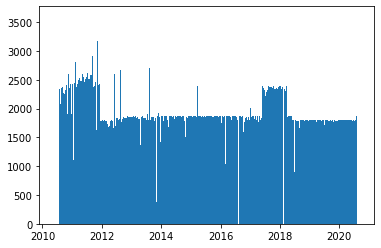

In [237]:
counts, bins, bars = plt.hist(hv['date'], bins=day_bins)

In [239]:
month_bins = pd.date_range(hv['date'].min(), hv['date'].max().replace(day=1)+pd.DateOffset(months=1), freq='M').to_period('M').to_timestamp()

In [322]:
n_days = 31
n_months = month_bins.size# ((day_bins[-1].year-day_bins[0].year)*12 + (day_bins[-1].month-day_bins[0].month)+1)
year_month = month_bins.year.astype(str) + ' ' + month_bins.month_name()# (year.year+year.month/12)#.astype(str)
hv_cov = pd.DataFrame(data=[[np.nan]*n_days]*n_months, index = year_month, columns=np.arange(1,32).astype(str), )
# hv_cov.index.name='Year'
# hv_cov.columns.name = 'Date'
hv_cov

In [323]:
idx_month_end = pd.Series(day_bins)[pd.Series(day_bins).dt.is_month_end].index
idx_month_end

Int64Index([   0,   30,   61,   92,  122,  153,  183,  214,  245,  273,
            ...
            3470, 3501, 3532, 3561, 3592, 3622, 3653, 3683, 3714, 3745],
           dtype='int64', length=124)

In [324]:
tot=0
for i in range(idx_month_end.size-1):
    hv_cov.iloc[i][:idx_month_end[i+1]-idx_month_end[i]] = counts[idx_month_end[i]+1:idx_month_end[i+1]+1]

Date,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
Year,,,,,,,,,,,,,,,,,,,,,
2010 June,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2122.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2010 July,36.0,0.0,0.0,0.0,0.0,0.0,2296.0,2224.0,3365.0,3266.0,...,0.0,0.0,0.0,2283.0,2348.0,813.0,1568.0,2341.0,2382.0,2336.0
2010 August,2303.0,2423.0,2210.0,2401.0,2365.0,2411.0,2681.0,2399.0,2412.0,2086.0,...,2449.0,2366.0,2050.0,2238.0,2205.0,2260.0,2402.0,361.0,2160.0,2197.0
2010 September,2099.0,2358.0,2399.0,2367.0,587.0,0.0,2279.0,2302.0,2230.0,2229.0,...,2223.0,1815.0,2296.0,2357.0,1559.0,2213.0,2327.0,2252.0,2247.0,NaN
2010 October,2411.0,2419.0,2336.0,2281.0,2388.0,2238.0,2236.0,2282.0,1832.0,1817.0,...,2398.0,2414.0,2403.0,2416.0,2031.0,2397.0,2305.0,2403.0,2355.0,2433.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020 April,1799.0,1798.0,1797.0,1795.0,1796.0,1797.0,1797.0,1799.0,1798.0,1799.0,...,1798.0,1797.0,1798.0,1796.0,1797.0,1799.0,1785.0,1797.0,1796.0,NaN
2020 May,1794.0,1796.0,1799.0,1797.0,1796.0,1795.0,1797.0,1797.0,1798.0,1800.0,...,1797.0,1796.0,1796.0,1795.0,1786.0,1798.0,1794.0,1704.0,1796.0,1796.0
2020 June,1793.0,1796.0,1792.0,1795.0,1798.0,1798.0,1798.0,1799.0,1780.0,1797.0,...,1795.0,1788.0,1799.0,1798.0,1762.0,1798.0,1799.0,1798.0,1799.0,NaN


In [326]:
df = pd.DataFrame(hv_cov.stack(), columns=['coverage']).reset_index()
# df['Year2'] = df['Year'].dt.year.astype(str) + ' ' + df['Year'].dt.month_name().astype('str')# (year.year+year.month/12)#.astype(str)

df['Year']=df['Year'].astype(str)

years = hv_cov.index.values#.astype(str)
dates = hv_cov.columns.values.astype(str)

colors = bp.Viridis[256]# ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
mapper = LinearColorMapper(palette=colors, low=np.nanmin(df.coverage), high=np.nanmax(df.coverage))

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

# output_file('AIA1600_coverage.html')
p = figure(title="AIA 1600 Coverage ({0} - {1})".format(years[0], years[-1]),
#            x_axis_type='datetime',
           x_range=years, y_range=list(reversed(dates)),
           x_axis_location="above", plot_width=1400, plot_height=800,
           x_axis_label="Year Month", y_axis_label="Date",
           tooltips=[('Date', '@Year @Date'), ('#Data Files', '@coverage')],
           tools=TOOLS, toolbar_location='below')

# p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi / 3
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"
p.xaxis.visible = True
p.xgrid.visible = True

p.xaxis.major_label_text_font_size = "7pt"
p.yaxis.major_label_text_font_size = "8pt"


p.rect(x="Year", y="Date", width=1, height=1,
       source=df,
       fill_color={'field': 'coverage', 'transform': mapper},
       line_color=None)

color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="10px",
                     ticker=BasicTicker(desired_num_ticks=10),
                     formatter=PrintfTickFormatter(format="%d"),
                     label_standoff=6, border_line_color=None, location=(0, 0))
p.add_layout(color_bar, 'right')

In [327]:
output_file('AIA1600_coverage.html')
show(p)